In [8]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import os

In [9]:
prototxtPath=os.path.sep.join(['/content/drive/MyDrive/TransferLearing Face Detector','deploy.prototxt'])
weightsPath=os.path.sep.join(['/content/drive/MyDrive/TransferLearing Face Detector','res10_300x300_ssd_iter_140000.caffemodel'])

In [10]:
prototxtPath

'/content/drive/MyDrive/TransferLearing Face Detector/deploy.prototxt'

In [11]:
weightsPath

'/content/drive/MyDrive/TransferLearing Face Detector/res10_300x300_ssd_iter_140000.caffemodel'

In [13]:
net=cv2.dnn.readNet(prototxtPath,weightsPath)

In [14]:
model=load_model('/content/drive/MyDrive/mask1_mobilnet_v2.model')

In [48]:
image=cv2.imread('/content/drive/MyDrive/640x-1.jpg')

In [49]:
image

array([[[199, 191, 191],
        [200, 192, 192],
        [202, 194, 194],
        ...,
        [244, 245, 243],
        [243, 244, 242],
        [242, 243, 241]],

       [[199, 191, 191],
        [201, 193, 193],
        [202, 194, 194],
        ...,
        [244, 245, 243],
        [243, 244, 242],
        [242, 243, 241]],

       [[200, 192, 192],
        [201, 193, 193],
        [203, 195, 195],
        ...,
        [244, 245, 243],
        [243, 244, 242],
        [243, 244, 242]],

       ...,

       [[117, 110, 117],
        [116, 109, 116],
        [115, 108, 115],
        ...,
        [ 92,  91, 100],
        [ 91,  90,  99],
        [ 91,  90,  99]],

       [[116, 109, 116],
        [115, 108, 115],
        [114, 107, 114],
        ...,
        [ 92,  91, 100],
        [ 92,  91, 100],
        [ 91,  90,  99]],

       [[115, 108, 115],
        [114, 107, 114],
        [113, 106, 113],
        ...,
        [ 92,  91, 100],
        [ 92,  91, 100],
        [ 92,  91, 100]]

In [50]:
(h,w)=image.shape[:2]

In [51]:
(h,w)

(359, 640)

In [52]:
blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177,123.0))

In [53]:
blob

array([[[[ 95.,  98.,  96., ..., 142., 141., 139.],
         [ 96.,  98.,  97., ..., 142., 141., 139.],
         [ 97.,  99.,  98., ..., 143., 141., 139.],
         ...,
         [ 13.,  10.,   7., ..., -16., -13., -13.],
         [ 12.,  10.,   7., ..., -16., -13., -13.],
         [ 10.,   9.,   6., ..., -16., -13., -12.]],

        [[ 15.,  17.,  15., ...,  70.,  69.,  66.],
         [ 15.,  17.,  16., ...,  70.,  68.,  66.],
         [ 16.,  18.,  17., ...,  71.,  69.,  67.],
         ...,
         [-67., -70., -72., ..., -90., -87., -87.],
         [-68., -70., -72., ..., -90., -87., -87.],
         [-70., -71., -73., ..., -90., -87., -86.]],

        [[ 69.,  71.,  69., ..., 122., 121., 118.],
         [ 69.,  71.,  70., ..., 122., 121., 119.],
         [ 70.,  72.,  71., ..., 123., 121., 119.],
         ...,
         [ -6.,  -9., -13., ..., -27., -24., -24.],
         [ -7.,  -9., -13., ..., -27., -24., -24.],
         [ -9., -10., -14., ..., -27., -24., -23.]]]], dtype=float32)

In [54]:
blob.shape

(1, 3, 300, 300)

In [55]:
net.setInput(blob)
detection=net.forward()

In [56]:
detection #array of the face

array([[[[0.        , 1.        , 0.99130636, ..., 0.2754015 ,
          0.6040825 , 0.82072496],
         [0.        , 1.        , 0.66131395, ..., 0.15295725,
          0.77720785, 0.53341067],
         [0.        , 1.        , 0.51527405, ..., 0.48119307,
          0.29640964, 0.87027335],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

In [57]:
#loop over the detections

for i in range(0,detection.shape[2]):
  confidence=detection[0,0,i,2]
  if confidence>0.5:
    box=detection[0,0,i,3:7]*np.array([w,h,w,h])
    (startX,starty,endX,endy)=box.astype('int')

    #we need to ensure the bounding boxes fall within the dimensons of the frame
    (startX,starty)=(max(0,startX),max(0,starty))
    (endX,endy)=(min(w-1,endX),min(h-1,endy))


    #extract the face ROI and convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
    face=image[starty:endy , startX:endX]
    face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
    face=cv2.resize(face,(224,224))
    face=img_to_array(face)
    face=preprocess_input(face)
    face=np.expand_dims(face,axis=0)

    (mask,withoutmask)=model.predict(face)[0]

    #determing the class label and color we will se yo draw the bounding box and text
    label='Mask' if mask>withoutmask else 'No Mask'
    color=(0,255,0) if label=='Mask' else (0,0,255)

    #include the propability in the lable
    label="{}: {:.2f}%".format(label,max(mask,withoutmask)*100)

    #display the label and bounding boxes
    cv2.putText(image,label,(startX,starty-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
    cv2.rectangle(image,(startX,starty),(endX,endy),color,2)


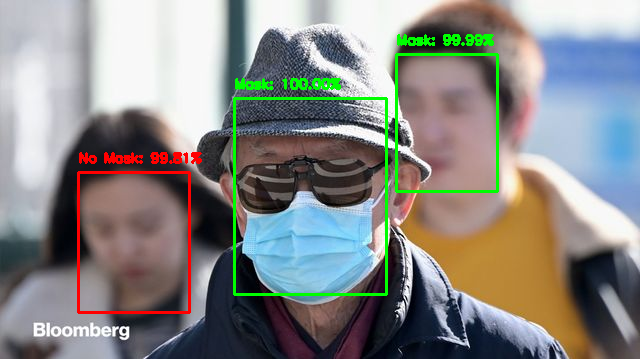

In [58]:
#cv2.imshow("Output",image)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()